In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NZZ/SPL"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn165251,MQDRGRRKSKSSDAAVQKVKKQPQRGMGVAQLERLRLQERWNNMTE...,243,1
1,Achn357291,MKKKKPPQRGMGVAQLERLRLQERWAKMALNNSPLQSLSPYDHPFY...,259,1
2,AA32G01105,MATSLFFISSTDHNNNNNTSLSTPNDHHLPSNTDLIRTTEPQKTRG...,318,1
3,evm_27.model.AmTr_v1.0_scaffold00072.24,MATTLLLWSPSGSPPPDDQTNDQDQENQPDQGRSRGRKSKINASGS...,293,1
4,Aqcoe1G240500.1.p,MAQEENQRCSNNNSSGGGVVRVSKKPKQKKIPQRGLGVAQLEKIRL...,435,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
108,0.009346,0.0,0.000000,0.002336,0.004673,0.000000,0.002336,0.002336,0.000000,0.000000,...,0.002336,0.002336,0.004673,0.0,0.007009,0.0,0.000000,0.0,0.0,0.000000
34,0.018018,0.0,0.000000,0.009009,0.000000,0.003003,0.000000,0.000000,0.003003,0.003003,...,0.000000,0.003003,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
11,0.007519,0.0,0.000000,0.007519,0.005013,0.002506,0.002506,0.002506,0.007519,0.000000,...,0.002506,0.002506,0.000000,0.0,0.005013,0.0,0.000000,0.0,0.0,0.002506
61,0.027778,0.0,0.002778,0.002778,0.000000,0.008333,0.002778,0.002778,0.002778,0.000000,...,0.002778,0.002778,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.002778
64,0.006006,0.0,0.000000,0.003003,0.000000,0.003003,0.003003,0.003003,0.000000,0.000000,...,0.000000,0.003003,0.000000,0.0,0.000000,0.0,0.003003,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (176, 426)
X_test: (45, 426)
y_train: (176,)
y_test: (45,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         109,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,577 (596.00 KB)

 Trainable params: 152,577 (596.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - accuracy: 0.3906 - loss: 0.6933

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4206 - loss: 0.6932 - val_accuracy: 0.9444 - val_loss: 0.6918


Epoch 2/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8125 - loss: 0.6918

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7715 - loss: 0.6916 - val_accuracy: 0.8056 - val_loss: 0.6899


Epoch 3/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8125 - loss: 0.6905

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7309 - loss: 0.6905 - val_accuracy: 0.8056 - val_loss: 0.6878


Epoch 4/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8594 - loss: 0.6878

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8875 - loss: 0.6873 - val_accuracy: 0.9722 - val_loss: 0.6838


Epoch 5/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.6842

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9291 - loss: 0.6834 - val_accuracy: 0.9167 - val_loss: 0.6778


Epoch 6/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 0.6793

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9031 - loss: 0.6781 - val_accuracy: 0.8889 - val_loss: 0.6703


Epoch 7/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8906 - loss: 0.6708

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8843 - loss: 0.6708 - val_accuracy: 0.9444 - val_loss: 0.6589


Epoch 8/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9219 - loss: 0.6606

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9086 - loss: 0.6601 - val_accuracy: 0.9722 - val_loss: 0.6456


Epoch 9/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.6424

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9740 - loss: 0.6411 - val_accuracy: 0.8889 - val_loss: 0.6305


Epoch 10/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9219 - loss: 0.6285

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9106 - loss: 0.6279 - val_accuracy: 0.9444 - val_loss: 0.6026


Epoch 11/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.6005

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9551 - loss: 0.5977 - val_accuracy: 0.9722 - val_loss: 0.5715


Epoch 12/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.5773

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9512 - loss: 0.5684 - val_accuracy: 0.8889 - val_loss: 0.5353


Epoch 13/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.5368

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9724 - loss: 0.5282 - val_accuracy: 0.9444 - val_loss: 0.4835


Epoch 14/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.4666

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9369 - loss: 0.4739 - val_accuracy: 1.0000 - val_loss: 0.4369


Epoch 15/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9219 - loss: 0.4546

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9418 - loss: 0.4297 - val_accuracy: 0.8889 - val_loss: 0.3908


Epoch 16/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.3575

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9350 - loss: 0.3725 - val_accuracy: 0.9444 - val_loss: 0.3259


Epoch 17/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.3099

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9480 - loss: 0.3153 - val_accuracy: 0.9722 - val_loss: 0.2745


Epoch 18/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.2714

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9815 - loss: 0.2699 - val_accuracy: 0.9444 - val_loss: 0.2094


Epoch 19/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.2117

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9568 - loss: 0.2049 - val_accuracy: 0.8889 - val_loss: 0.2385


Epoch 20/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9219 - loss: 0.2532

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9418 - loss: 0.2162 - val_accuracy: 0.9722 - val_loss: 0.1353


Epoch 21/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1284

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9834 - loss: 0.1234 - val_accuracy: 0.9722 - val_loss: 0.1127


Epoch 22/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.1662

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9568 - loss: 0.1286 - val_accuracy: 0.9167 - val_loss: 0.1440


Epoch 23/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0526

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9799 - loss: 0.0863 - val_accuracy: 1.0000 - val_loss: 0.0825


Epoch 24/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0735

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9795 - loss: 0.0783 - val_accuracy: 0.9722 - val_loss: 0.0976



[Train Accuracy: 97.86% - Test Accuracy: 95.56%]


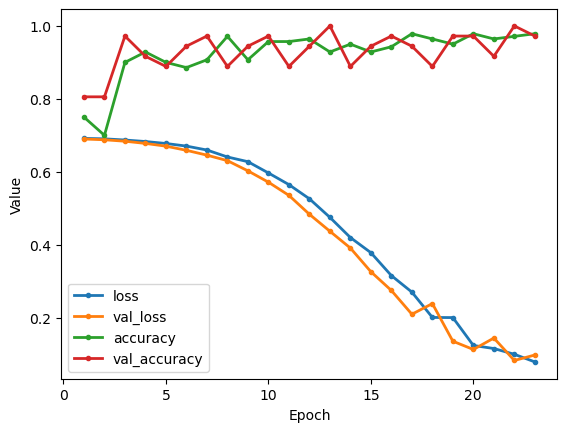

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYL,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYY
108,0.004684,0.0,0.0,0.000000,0.0,0.0,0.000000,0.002342,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.009036,0.0,0.0,0.003012,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.0,0.0,0.000000,0.0,0.0,0.002513,0.002513,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.016713,0.0,0.0,0.002786,0.0,0.0,0.000000,0.000000,0.002786,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.003012,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (176, 7585)
X_test: (45, 7585)
y_train: (176,)
y_test: (45,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       1,942,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,985,281 (7.57 MB)

 Trainable params: 1,985,281 (7.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step - accuracy: 0.6094 - loss: 0.6931

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5384 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6927


Epoch 2/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5312 - loss: 0.6923

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5244 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6913


Epoch 3/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5312 - loss: 0.6905

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5663 - loss: 0.6896 - val_accuracy: 0.5278 - val_loss: 0.6887


Epoch 4/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7188 - loss: 0.6838

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6538 - loss: 0.6849 - val_accuracy: 0.5278 - val_loss: 0.6840


Epoch 5/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6094 - loss: 0.6802

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6245 - loss: 0.6780 - val_accuracy: 0.5556 - val_loss: 0.6764


Epoch 6/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7188 - loss: 0.6714

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7497 - loss: 0.6665 - val_accuracy: 0.6667 - val_loss: 0.6641


Epoch 7/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8438 - loss: 0.6577

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8820 - loss: 0.6499 - val_accuracy: 0.7222 - val_loss: 0.6462


Epoch 8/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8750 - loss: 0.6274

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8768 - loss: 0.6253 - val_accuracy: 0.7500 - val_loss: 0.6216


Epoch 9/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9688 - loss: 0.5929

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9665 - loss: 0.5899 - val_accuracy: 0.8056 - val_loss: 0.5883


Epoch 10/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9688 - loss: 0.5704

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9756 - loss: 0.5457 - val_accuracy: 0.7778 - val_loss: 0.5477


Epoch 11/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.4831

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9649 - loss: 0.4853 - val_accuracy: 0.7500 - val_loss: 0.5082


Epoch 12/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9688 - loss: 0.4196

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9646 - loss: 0.4225 - val_accuracy: 0.8333 - val_loss: 0.4372


Epoch 13/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.3529

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9964 - loss: 0.3457 - val_accuracy: 1.0000 - val_loss: 0.3633


Epoch 14/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.2992

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.2777 - val_accuracy: 1.0000 - val_loss: 0.2905


Epoch 15/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.2211

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.2032 - val_accuracy: 0.9722 - val_loss: 0.2427


Epoch 16/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.1691

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1512 - val_accuracy: 1.0000 - val_loss: 0.1785


Epoch 17/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0991

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0928 - val_accuracy: 1.0000 - val_loss: 0.1125


Epoch 18/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0570

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0552 - val_accuracy: 1.0000 - val_loss: 0.0778


Epoch 19/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0381

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0373 - val_accuracy: 1.0000 - val_loss: 0.0587


Epoch 20/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0202

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0388


Epoch 21/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0142

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.0242


Epoch 22/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0069

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0190


Epoch 23/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0049

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0163



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


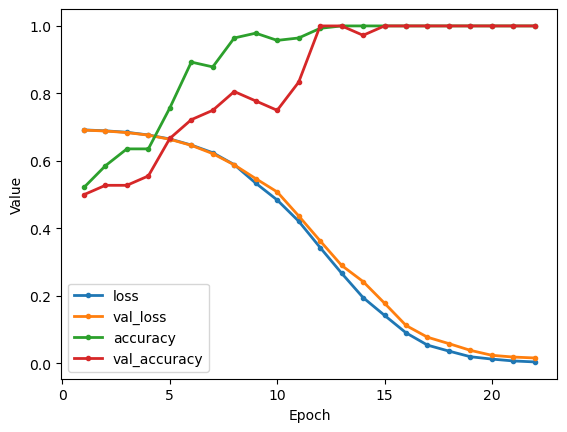

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,AAAM,...,YYST,YYTA,YYTT,YYVD,YYVP,YYVV,YYYH,YYYN,YYYT,YYYY
108,0.002347,0.0,0.000000,0.0,0.0,0.0,0.002347,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.000000,0.0,0.003021,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.011173,0.0,0.002793,0.0,0.0,0.0,0.000000,0.002793,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      11,344,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,385,345 (43.43 MB)

 Trainable params: 11,385,345 (43.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - accuracy: 0.6094 - loss: 0.6931

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5661 - loss: 0.6931 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5621 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6926


Epoch 2/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6094 - loss: 0.6916

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5467 - loss: 0.6921

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5368 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6913


Epoch 3/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5625 - loss: 0.6890

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5479 - loss: 0.6892

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5484 - loss: 0.6892 - val_accuracy: 0.6944 - val_loss: 0.6888


Epoch 4/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7188 - loss: 0.6858

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7567 - loss: 0.6849

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7640 - loss: 0.6847 - val_accuracy: 0.6111 - val_loss: 0.6849


Epoch 5/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7188 - loss: 0.6777

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7272 - loss: 0.6776

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7276 - loss: 0.6776 - val_accuracy: 0.6944 - val_loss: 0.6789


Epoch 6/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8438 - loss: 0.6716

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8931 - loss: 0.6672

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9002 - loss: 0.6666 - val_accuracy: 0.8611 - val_loss: 0.6710


Epoch 7/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.6551

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.6509 - val_accuracy: 0.9444 - val_loss: 0.6594


Epoch 8/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.6342

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.6290

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.6281 - val_accuracy: 0.8611 - val_loss: 0.6404


Epoch 9/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.5978

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.5963

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.5958 - val_accuracy: 0.8611 - val_loss: 0.6156


Epoch 10/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.5521

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.5510 - val_accuracy: 0.9167 - val_loss: 0.5863


Epoch 11/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.5068

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.4988 - val_accuracy: 1.0000 - val_loss: 0.5531


Epoch 12/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.4554

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.4364 - val_accuracy: 1.0000 - val_loss: 0.5061


Epoch 13/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.3927

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.3743

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.3719 - val_accuracy: 0.9167 - val_loss: 0.4504


Epoch 14/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.2910

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.2886

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.2879 - val_accuracy: 0.9722 - val_loss: 0.3909


Epoch 15/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.2342

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2196

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.2172 - val_accuracy: 1.0000 - val_loss: 0.3303


Epoch 16/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.1496

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.1405

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.1395 - val_accuracy: 1.0000 - val_loss: 0.2764


Epoch 17/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0981

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0922

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0910 - val_accuracy: 1.0000 - val_loss: 0.2298


Epoch 18/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0540

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0496

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0488 - val_accuracy: 1.0000 - val_loss: 0.1865


Epoch 19/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0321

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0300

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.1540


Epoch 20/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0179

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.1313


Epoch 21/100


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0102

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0099

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.1138



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


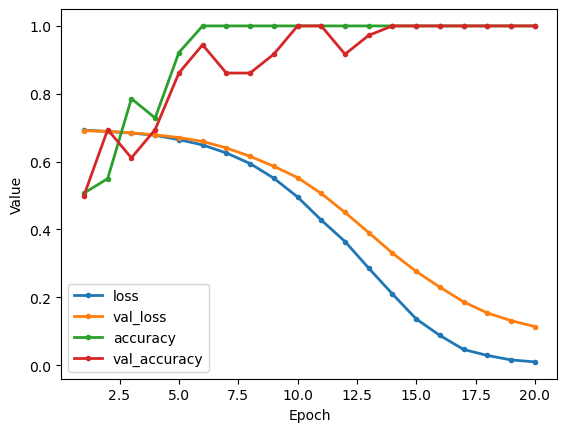

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [26]:
report.save()

Report saved as Output/Reports/NZZ__SPL/report_SJGAYLJ0.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################